In [1]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')



def create_model(column):
    
    if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column)):
        os.makedirs('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))

    if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column)):
        os.makedirs('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))

    LOG_PATH = Path('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))
    DATA_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary/')
    LABEL_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary/')
    OUTPUT_PATH = Path('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))
    FINETUNED_PATH = None

    args = Box({
        "run_text": "labor mturk ar 6 binary",
        "train_size": -1,
        "val_size": -1,
        "log_path": LOG_PATH,
        "full_data_dir": DATA_PATH,
        "data_dir": DATA_PATH,
        "task_name": "labor_market_classification",
        "no_cuda": False,
        #     "bert_model": BERT_PRETRAINED_PATH,
        "output_dir": OUTPUT_PATH,
        "max_seq_length": 512,
        "do_train": True,
        "do_eval": True,
        "do_lower_case": True,
        "train_batch_size": 8,
        "eval_batch_size": 16,
        "learning_rate": 5e-5,
        "num_train_epochs": 100,
        "warmup_proportion": 0.0,
        "no_cuda": False,
        "local_rank": -1,
        "seed": 42,
        "gradient_accumulation_steps": 1,
        "optimize_on_cpu": False,
        "fp16": False,
        "fp16_opt_level": "O1",
        "weight_decay": 0.0,
        "adam_epsilon": 1e-8,
        "max_grad_norm": 1.0,
        "max_steps": -1,
        "warmup_steps": 500,
        "logging_steps": 50,
        "eval_all_checkpoints": True,
        "overwrite_output_dir": True,
        "overwrite_cache": True,
        "seed": 42,
        "loss_scale": 128,
        "task_name": 'intent',
        "model_name": 'bert-base-uncased',
        "model_type": 'bert'
    })

    import logging

    logfile = str(LOG_PATH / 'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        handlers=[
            logging.FileHandler(logfile),
            logging.StreamHandler(sys.stdout)
        ])

    logger = logging.getLogger()

    logger.info(args)

    device = torch.device('cuda')
    if torch.cuda.device_count() > 1:
        args.multi_gpu = True
    else:
        args.multi_gpu = False

    label_cols = ['pos']

    databunch = BertDataBunch(
        args['data_dir'],
        LABEL_PATH,
        args.model_name,
        train_file='train_{}.csv'.format(column),
        val_file='val_{}.csv'.format(column),
        label_file='label_{}.csv'.format(column),
        # test_data='test.csv',
        text_col="text",  # this is the name of the column in the train file that containts the tweet text
        label_col=label_cols,
        batch_size_per_gpu=args['train_batch_size'],
        max_seq_length=args['max_seq_length'],
        multi_gpu=args.multi_gpu,
        multi_label=False,
        model_type=args.model_type)

    num_labels = len(databunch.labels)
    print('num_labels', num_labels)

    print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')

    # metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
    metrics = []
    # metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
    # metrics.append({'name': 'roc_auc', 'function': roc_auc})
    # metrics.append({'name': 'fbeta', 'function': fbeta})
    metrics.append({'name': 'accuracy', 'function': accuracy})
    metrics.append({'name': 'roc_auc_save_to_plot', 'function': roc_auc_save_to_plot})
    # metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})

    learner = BertLearner.from_pretrained_model(
        databunch,
        pretrained_path='../mturk_mar6/output_binary_{}/model_out_2/'.format(column), 
        metrics=metrics,
        device=device,
        logger=logger,
        output_dir=args.output_dir,
        finetuned_wgts_path=FINETUNED_PATH,
        warmup_steps=args.warmup_steps,
        multi_gpu=args.multi_gpu,
        is_fp16=args.fp16,
        multi_label=False,
        logging_steps=0)
    
    return learner

/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [4]:
trained_model = create_model('is_unemployed')


04/03/2020 16:06:07 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_unemployed'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_is_unemployed'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'overwrite

In [5]:
# from fast_bert.metrics import *
trained_model.validate()

04/03/2020 16:06:30 - INFO - root -   Running evaluation
04/03/2020 16:06:31 - INFO - root -     Num examples = 1101
04/03/2020 16:06:31 - INFO - root -     Batch size = 16


IndexError: too many indices for array

In [ ]:
import pickle
def roc_auc_save_to_plot(y_pred: Tensor, y_true: Tensor):
    # ROC-AUC calcualation
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    num_classes = 5
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    output = {'fpr':fpr, 'tpr':tpr, 'roc_auc':roc_auc}

#     with open('/scratch/da2734/twitter/roc_auc_save_to_plot.pkl', 'wb') as config_dictionary_file:
#         pickle.dump(config_dictionary, config_dictionary_file)

    pickle.dump( output, open( "/scratch/da2734/twitter/roc_auc_save_to_plot.pkl", "wb" ) )

    return roc_auc["micro"]

In [7]:
import pickle
output = pickle.load( open( "/scratch/da2734/twitter/roc_auc_save_to_plot.pkl", "rb" ) )


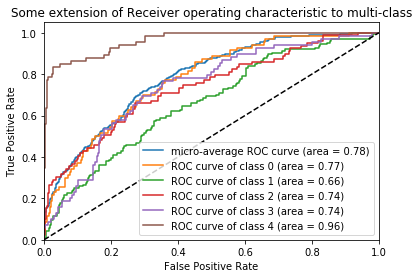

In [21]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

fpr = output['fpr']
tpr = output['tpr']
roc_auc = output['roc_auc']
num_classes = 5

# Plot ROC curve
plt.figure()

plt.plot(fpr["micro"], tpr["micro"],label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--') #line y=x
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [10]:
from fast_bert.metrics import *
import inspect
roc_auc_code = inspect.getsource(roc_auc)
print(roc_auc_code)

def roc_auc(y_pred: Tensor, y_true: Tensor):
    # ROC-AUC calcualation
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()

    print(y_true)
    # Compute micro-average ROC curve and ROC area
 
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_labels_roc = roc_auc_score(y_true.ravel(), y_pred.ravel(), average=None)
    print('all_labels_roc', all_labels_roc)

#    print('roc_auc', roc_auc) 
    return roc_auc["micro"]



In [9]:
learner.validate()

02/26/2020 15:46:16 - INFO - root -   Running evaluation
02/26/2020 15:46:16 - INFO - root -     Num examples = 559
02/26/2020 15:46:16 - INFO - root -     Batch size = 16


{'loss': 0.38508442512580326,
 'accuracy_thresh': 0.8540250062942505,
 'roc_auc': 0.7829953095607745,
 'fbeta': 0.12640202045440674,
 'accuracy': 0.0,
 'accuracy_multilabel': 0.30590339892665475}

In [18]:
# texts = ['I just received a job offer']
texts = ["currently, unemployed. mixed emotions about it. it's been real ohio! #backtothebluegrass"]
predictions = learner.predict_batch(texts)
print(predictions[0])

02/26/2020 16:32:04 - INFO - root -   Writing example 0 of 1
[('is_unemployed', 0.20506545901298523), ('job_loss', 0.18410015106201172), ('is_hired', 0.18227609992027283), ('job_offer', 0.1583184450864792), ('job_search', 0.15347689390182495)]


In [17]:
# https://github.com/kaushaltrivedi/fast-bert/blob/master/fast_bert/data_cls.py
# print(databunch.train_dl.sampler())
# print(enumerate(databunch.train_dl.dataset))
print(type(databunch.train_dl.dataset))
print(len(databunch.train_dl.dataset)) #-> 1303 tweets (i'm pretty sure)
print(len(databunch.train_dl.dataset[0])) # -> 4 objects: all_input_ids, all_input_mask, all_segment_ids, all_label_ids
print(databunch.train_dl.dataset[0][3])

<class 'torch.utils.data.dataset.TensorDataset'>
1303
4
tensor([0., 0., 0., 1., 0.])
